# ATG_DealLI_Exceptions_ML_OI_Predictions

## Importing Libraries

In [1]:
from pandas import set_option,concat,DataFrame,Series,to_numeric,to_datetime,options,read_csv,read_excel
from numpy import concatenate,random,unique,round
from pyodbc import connect
from warnings import filterwarnings
# from matplotlib.pyplot import subplots,tight_layout,savefig,close,figure,scatter,plot,title,legend
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.metrics import median_absolute_error,r2_score,max_error
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor,HistGradientBoostingRegressor 
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
#from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeRegressor#,plot_tree
from sklearn.model_selection import GridSearchCV,train_test_split#,cross_val_score
from sklearn.preprocessing import StandardScaler#,LabelBinarizer,label_binarize,MaxAbsScaler
#from sklearn.feature_extraction import FeatureHasher
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from IPython.display import clear_output
from sklearn.neighbors import *
from re import search#,match
from random import randint
from time import time
from smtplib import SMTP_SSL
from ssl import create_default_context
from os import path,walk
from zipfile import ZipFile, ZIP_DEFLATED
from datetime import datetime
from time import time#,sleep

In [2]:
filterwarnings('ignore')
set_option('display.max_rows', None)
set_option('display.max_columns', None)

## SQL Connect

In [3]:
server = 'troy'
database = 'prod_Costco_RecoverNow'
connectionString = f'DRIVER={{ODBC Driver 17 for SQL Server}};SERVER={server};DATABASE={database};Integrated Security={True};Autocommit={True};Trusted_Connection=yes;'
conn = connect(connectionString)
cursor_1 = conn.cursor()

## Supporting Functions

In [92]:
def export_to_sql(data: DataFrame):
    server = 'barney'
    database = 'sandbox_mp'
    connectionString = f'DRIVER={{ODBC Driver 17 for SQL Server}};SERVER={server};DATABASE={database};Integrated Security={True};Autocommit={True};Trusted_Connection=yes;'
    conn = connect(connectionString)
    cursor = conn.cursor()
    insert_sql = """
        INSERT INTO Weis_Market_Claim_Discrepancies_PdOI_ATG (
            ATG_DealLI_Exceptions_IsClaimFlg,
            ATG_DealLI_Exceptions_Checked,
            ATG_DealLI_Exceptions_ATG_Ref,
            ATG_DealLI_Exceptions_LI_ATG_Ref,
            ATG_DealLI_Exceptions_BatchNbr,
            ATG_DealLI_Exceptions_CATEGORY_ATG,
            ATG_DealLI_Exceptions_ClaimType,
            ATG_DealLI_Exceptions_AP_VndNbr,
            ATG_DealLI_Exceptions_AP_VndrName,
            ATG_DealLI_Exceptions_OOB_ATG,
            ATG_DealLI_Exceptions_ItemNbr,
            ATG_DealLI_Exceptions_UPCNbr,
            ATG_DealLI_Exceptions_UPCUnit,
            ATG_DealLI_Exceptions_ItemDescription,
            ATG_DealLI_Exceptions_ItemShipPack,
            ATG_DealLI_Exceptions_PoNbr,
            ATG_DealLI_Exceptions_PODate,
            ATG_DealLI_Exceptions_ReceivingDate,
            ATG_DealLI_Exceptions_TurnRatio_ATG,
            ATG_DealLI_Exceptions_TurnQty_ATG,
            ATG_DealLI_Exceptions_OrdQty,
            ATG_DealLI_Exceptions_PdQty_ATG,
            ATG_DealLI_Exceptions_PdGross_ATG,
            ATG_DealLI_Exceptions_PdBB_ATG,
            ATG_DealLI_Exceptions_PdNet_ATG,
            ATG_DealLI_Exceptions_DealNbr,
            ATG_DealLI_Exceptions_OrdStartDate_ATG,
            ATG_DealLI_Exceptions_OrdEndDate_ATG,
            ATG_DealLI_Exceptions_DateStartArrival_ATG,
            ATG_DealLI_Exceptions_DateEndArrival_ATG,
            ATG_DealLI_Exceptions_DLAmtOI,
            ATG_DealLI_Exceptions_DLAmtBB,
            ATG_DealLI_Exceptions_PdOI_ATG_Before_AI,
            Linear_Model_Predictions_ATG_DealLI_Exceptions_PdOI_ATG,
            DecisionTree_Model_Predictions_ATG_DealLI_Exceptions_PdOI_ATG,
            RandomForest_Predictions_ATG_DealLI_Exceptions_PdOI_ATG,
            XGBoost_Model_Predictions_ATG_DealLI_Exceptions_PdOI_ATG,
            GradientBoost_Model_Predictions_ATG_DealLI_Exceptions_PdOI_ATG,
            LGBM_Model_Predictions_ATG_DealLI_Exceptions_PdOI_ATG,
            CatBoost_Model_Predictions_ATG_DealLI_Exceptions_PdOI_ATG,
            KNeighbors_Model_Predictions_ATG_DealLI_Exceptions_PdOI_ATG
        ) VALUES (?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?)
    """
    for row in data.index:
        if(int(row)%100==0):
            clear_output(wait=False)
            print(f"{row:,}")
        current_row = list(data.iloc[int(row)])
        del current_row[33]
        cols = list(data.columns)
        for index in range(len(current_row)):
            if(index>=33):
                current_row[index] = round(current_row[index],4)
            if(index in [2,3,4]):
                current_row[index] = int(current_row[index])
            else:
                current_row[index] = str(current_row[index])
        current_row.insert(33,current_row[23])
        del current_row[23]
        cursor.execute(insert_sql, current_row)
        conn.commit()
    cursor.close()
    conn.close()

In [4]:
def scatter_plot_models(target: Series,predictions: Series,model_name: str, show: bool=False):
    plt.figure(figsize=(6,5))
    plt.scatter(target,predictions,color='blue',label='Test_Data',linewidths=.1)
    plt.plot([Series(target).min(),Series(target).max()],
            [Series(target).min(),Series(target).max()],'k--',lw=1)
    plt.xlabel('PdOI_ATG_Before_AI')
    plt.ylabel('PdOI_ATG_After_AI')
    plt.savefig(f"C:/Code/Python/Machine_Learning_AI/Model_Analysis/{model_name}_Scatter.png")
    if(show):
        plt.show()
    else:
        plt.close()

In [5]:
def get_scores(target, predictions):
    mse = mean_squared_error(target, predictions)
    rmse = mse**0.5
    median_ae = median_absolute_error(target,predictions)
    mean_ae = mean_absolute_error(target,predictions)
    max_errors = max_error(target,predictions)
    r2 = r2_score(target,predictions)
    display(concat([target,predictions],axis=1).head(25))
    return [mse,rmse,mean_ae,median_ae,max_errors,r2]

In [6]:
def run_and_analyze_model(model,features_train: DataFrame,target_train: Series,features_test: Series,target_test: Series,model_scores: DataFrame,model_name: str):
    model.fit(features_train,target_train)
    predictions = Series(model.predict(features_test),name=model_name)
    model_scores.loc[model_name] = get_scores(target_test,predictions)
    try:
        model_importances = DataFrame([model.feature_importances_],columns=features_train.columns,index=[model_name]).T
        return model,predictions,model_scores,model_importances
    except:
        model_importances = DataFrame([[1/len(features_train.columns) for _ in range(len(features_train.columns))]],columns=list(features_train.columns),index=[model_name]).T
        return model,predictions,model_scores,model_importances

In [7]:
def empty_string_to_null(string: str):
    if(len(str(string))==0 or len(str(string).replace(' ',''))==0):
        return "None"
    return string

In [8]:
def object_to_int(original,lookup_table):
    for row in lookup_table.index:
        for col in lookup_table.columns:
            if(original==lookup_table[col][row]):
                return int(col)

In [9]:
def random_int(min_val, max_val):
    # Get the current time in microseconds
    current_time = int(time() * 1000000)
    
    # Use the current time as a seed and perform some operations to get more randomness
    seed = (current_time ^ (current_time >> randint(1,20))) & 0xFFFFFFFF
    seed = (seed ^ (seed << randint(1,20))) & 0xFFFFFFFF
    seed = (seed ^ (seed >> randint(1,20))) & 0xFFFFFFFF
    
    # Scale the seed to the desired range
    random_value = min_val + (seed % (max_val - min_val + 1))
    
    return random_value

In [10]:
def random_features(columns):
    subset = []
    columns = list(columns)
    while(len(subset)<50):
        random_index = random_int(0,len(list(columns))-1)
        while(columns[random_index] in subset):
            random_index = random_int(0,len(list(columns))-1)
        subset.append(columns[random_index])
    return subset

In [11]:
def send_email_to_self(subject: str,body: str):
    port = 465  # For SSL
    smtp_server = "smtp.gmail.com"
    sender_email = "micpowers98@gmail.com"  # Enter your address
    receiver_email = "micpowers98@gmail.com"  # Enter receiver address
    password = 'efex cwhv gppq ueob'
    message = "Subject: "+subject+"\n"+body

    context = create_default_context()
    with SMTP_SSL(smtp_server, port, context=context) as server:
        server.login(sender_email, password)
        server.sendmail(sender_email, receiver_email, message)

In [12]:
def get_data(columns: list):
	cursor_1.execute("""
			select 
				case when (li.checked='true' and ds.checked='claim') then 'Y' else 'N' end as IsClaimFlg, li.checked,
					li.[ATG_Ref],
					li.[ATG_LI_Ref],
					li.[BatchNbr],
					li.[CATEGORY_ATG],
					li.[ClaimType],
					li.[AP_VndNbr],
					li.[APVndrName],
					li.[OOB_ATG],
					li.[ItemNbr],
					li.[UPCNbr],
					li.[UPCUnit],
					li.[ItemDescription],
					li.[ItemShipPack],
					li.[PoNbr],
					li.[PODate],
					li.[ReceivingDate],
					li.[TurnRatio_ATG],
					li.[TurnQty_ATG],
					li.[OrdQty],
					li.[PdQty_ATG],
					li.[PdGross_ATG],
					li.[PdOI_ATG],
					li.[PdBB_ATG],
					li.[PdNet_ATG],
					li.[DealNbr],
					li.[OrdStartDate_ATG],
					li.[OrdEndDate_ATG],
					li.[DateStartArrival_ATG],
					li.[DateEndArrival_ATG],
					li.[DLAmtOI],
					li.[DLAmtBB]
			from     
				[MOE].[prod_WeisMarkets_RecoverNow].[dbo].[ATG_DealLI_Exceptions] li
						join  [MOE].[prod_WeisMarkets_RecoverNow].[dbo].[ATG_Deal_Summary] ds
						on (li.BatchNbr = ds.BatchNbr)
						and (li.DLVendorNbr = ds.DLVendorNbr)
						and (li.DealNbr = ds.DealNbr)
						and (li.CATEGORY_ATG = ds.CATEGORY_ATG)
						and (li.ClaimType = ds.ClaimType_ATG)
			where li.ClaimType = 'IN DEAL' and ds.CATEGORY_ATG = 'SAME VENDOR - AMT DEALS'
			order by 8,12,17			
		""")
	train_data = cursor_1.fetchall()
	train_data_list = []
	for index in range(len(train_data)):
		train_data_list.append(list(train_data[index]))
	del train_data
	return DataFrame(data=train_data_list,columns=columns)

In [13]:
def get_test_data(batch_number: int, columns: list):
    cursor_1.execute(f"""
		    select 
                case when (li.checked = 'true' and ds.checked = 'claim') then 'Y' else 'N' end as IsClaimFlg, li.Checked, 
                    li.[ATG_Ref],
                    li.[ATG_LI_Ref],
                    li.[BatchNbr],
                    li.[CATEGORY_ATG],
                    li.[ClaimType],
                    li.[AP_VndNbr],
                    li.[APVndrName],
                    li.[OOB_ATG],
                    li.[ItemNbr],
                    li.[UPCNbr],
                    li.[UPCUnit],
                    li.[ItemDescription],
                    li.[ItemShipPack],
                    li.[PoNbr],
                    li.[PODate],
                    li.[ReceivingDate],
                    li.[TurnRatio_ATG],
                    li.[TurnQty_ATG],
                    li.[OrdQty],
                    li.[PdQty_ATG],
                    li.[PdGross_ATG],
                    li.[PdOI_ATG],
                    li.[PdBB_ATG],
                    li.[PdNet_ATG],
                    li.[DealNbr],
                    li.[OrdStartDate_ATG],
                    li.[OrdEndDate_ATG],
                    li.[DateStartArrival_ATG],
                    li.[DateEndArrival_ATG],
                    li.[DLAmtOI],
                    li.[DLAmtBB]--,
			    from    
                    [MOE].[prod_WeisMarkets_RecoverNow].[dbo].[ATG_DealLI_Exceptions] li
                    join  [MOE].[prod_WeisMarkets_RecoverNow].[dbo].[ATG_Deal_Summary]  ds
                    on (li.BatchNbr = ds.BatchNbr)
                    and (li.DLVendorNbr = ds.DLVendorNbr)
                    and (li.DealNbr = ds.DealNbr)
                    and (li.CATEGORY_ATG = ds.CATEGORY_ATG)
                    and (li.ClaimType = ds.ClaimType_ATG)
                where
                    li.BatchNbr=67
                    and
                    li.ClaimType = 'IN DEAL' 
                    and 
                    ds.CATEGORY_ATG = 'SAME VENDOR - AMT DEALS' 
                    and 
                    li.checked='x' 
                    and 
                    ds.checked='x'

		    union

			select top(1) 
                case when (li.checked = 'true' and ds.checked = 'claim') then 'Y' else 'N' end as IsClaimFlg, li.Checked, 
                    li.[ATG_Ref],
                    li.[ATG_LI_Ref],
                    li.[BatchNbr],
                    li.[CATEGORY_ATG],
                    li.[ClaimType],
                    li.[AP_VndNbr],
                    li.[APVndrName],
                    li.[OOB_ATG],
                    li.[ItemNbr],
                    li.[UPCNbr],
                    li.[UPCUnit],
                    li.[ItemDescription],
                    li.[ItemShipPack],
                    li.[PoNbr],
                    li.[PODate],
                    li.[ReceivingDate],
                    li.[TurnRatio_ATG],
                    li.[TurnQty_ATG],
                    li.[OrdQty],
                    li.[PdQty_ATG],
                    li.[PdGross_ATG],
                    li.[PdOI_ATG],
                    li.[PdBB_ATG],
                    li.[PdNet_ATG],
                    li.[DealNbr],
                    li.[OrdStartDate_ATG],
                    li.[OrdEndDate_ATG],
                    li.[DateStartArrival_ATG],
                    li.[DateEndArrival_ATG],
                    li.[DLAmtOI],
                    li.[DLAmtBB]--,
			    from     
                    [MOE].[prod_WeisMarkets_RecoverNow].[dbo].[ATG_DealLI_Exceptions] li
                    join  [MOE].[prod_WeisMarkets_RecoverNow].[dbo].[ATG_Deal_Summary]  ds
                    on (li.BatchNbr = ds.BatchNbr)
                    and (li.DLVendorNbr = ds.DLVendorNbr)
                    and (li.DealNbr = ds.DealNbr)
                    and (li.CATEGORY_ATG = ds.CATEGORY_ATG)
                    and (li.ClaimType = ds.ClaimType_ATG)
			where
                li.ClaimType = 'IN DEAL' 
                and 
                ds.CATEGORY_ATG = 'SAME VENDOR - AMT DEALS' 
                and 
                li.checked='true' 
                and 
                ds.checked='claim'
        """)
    test_data = cursor_1.fetchall()
    test_data_list = []
    for index in range(len(test_data)):
        test_data_list.append(list(test_data[index]))
    del test_data
    return DataFrame(data=test_data_list,columns=columns)

In [14]:
def compress_folder_to_zip(folder_path, output_zip_file):
    # Create a ZipFile object
    with ZipFile(output_zip_file, 'w', ZIP_DEFLATED) as zipf:
        # Walk through the folder
        for root, dirs, files in walk(folder_path):
            for file in files:
                # Create the full file path
                file_path = path.join(root, file)
                # Add file to zip, using relative path to maintain folder structure
                arcname = path.relpath(file_path, start=folder_path)
                zipf.write(file_path, arcname=arcname)

## Global Variables

In [15]:
columns: list = ['IsClaimFlg','Checked','ATG_Ref','ATG_LI_Ref','BatchNbr','CATEGORY_ATG','ClaimType','AP_VndNbr','APVndrName',
                 'OOB_ATG','ItemNbr','UPCNbr','UPCUnit','ItemDescription','ItemShipPack','PoNbr','PODate','ReceivingDate','TurnRatio_ATG',
                 'TurnQty_ATG','OrdQty','PdQty_ATG','PdGross_ATG','PdOI_ATG','PdBB_ATG','PdNet_ATG','DealNbr','OrdStartDate_ATG',
                 'OrdEndDate_ATG','DateStartArrival_ATG','DateEndArrival_ATG','DLAmtOI','DLAmtBB']

In [16]:
upc_number = '76172005820'

## Open Initial Data

In [17]:
train: DataFrame = get_data(columns=columns)
#train: DataFrame = read_excel('Top_10000_Rows_Order_By_UPC.xlsx')

In [18]:
train.info(max_cols=250)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1019271 entries, 0 to 1019270
Data columns (total 33 columns):
 #   Column                Non-Null Count    Dtype         
---  ------                --------------    -----         
 0   IsClaimFlg            1019271 non-null  object        
 1   Checked               1019271 non-null  object        
 2   ATG_Ref               1019271 non-null  int64         
 3   ATG_LI_Ref            1019271 non-null  int64         
 4   BatchNbr              1019271 non-null  int64         
 5   CATEGORY_ATG          1019271 non-null  object        
 6   ClaimType             1019271 non-null  object        
 7   AP_VndNbr             1019271 non-null  object        
 8   APVndrName            1019271 non-null  object        
 9   OOB_ATG               1019271 non-null  object        
 10  ItemNbr               1019271 non-null  int64         
 11  UPCNbr                1019271 non-null  int64         
 12  UPCUnit               1019271 non-null  in

In [19]:
subject = 'Data Collected'
body = f"""
        {len(train):,} total rows of data for UPC {upc_number}.
    """
#send_email_to_self(subject,body)

## Data Preprocessing

### Dropping Useless Columns

In [20]:
for col in train.columns:
    if train[col].dtype == 'object':
        try:
            train[col] = train[col].astype(float)
        except:
            try:
                train[col] = train[col].astype(int)
            except Exception as e: pass

In [21]:
empty_col = []
for col in train.columns:
    if train[col].dtype == 'object':
        if(train[col].nunique()>1000):
            print(col)
            empty_col.append(col)
train = train.drop(empty_col,axis=1)

ItemDescription


### Converting Numerical Strings to Numbers

In [22]:
for col in train.columns:
    if train[col].dtype == 'object' and not(col=='PdOI_ATG'):
        try:
            train[col] = train[col].astype(float)
        except:
            try:
                train[col] = train[col].astype(int)
            except Exception as e: pass

In [23]:
for col in train.columns:
    if train[col].dtype == 'object' and not(col=='PdOI_ATG'):
        try:
            train[col] = train[col].astype(float)
        except:
            try:
                train[col] = train[col].astype(int)
            except Exception as e: pass

In [24]:
category_values = {}
category_new_values = {}
for col in train.columns:
    if train[col].dtype == 'object' and train[col].nunique()<=1000 and not(col=='PdOI_ATG'):
        train[col] = train[col].apply(empty_string_to_null)
        # categorical_columns.append(col)
        category_values[col] = Series(list(train[col].unique())).unique()

In [25]:
max_length = 0
for key,item in category_values.items():
    if(len(item)>max_length):
        max_length = len(item)
for key in category_values:
    category_values[key] = concatenate((category_values[key],['None'] * (max_length - len(category_values[key]))))
lookup_table = DataFrame.from_dict(category_values, orient='index')
lookup_table.columns = range(max_length)
for col in lookup_table.columns:
    lookup_table[col] = lookup_table[col].astype(str)
#lookup_table.to_csv(f'C:/Code/Python/Machine_Learning_AI/Lookup_Table_Batch_{batch_number}.csv')
lookup_table.to_csv(f"C:/Code/Python/Machine_Learning_AI/Lookup_Table.csv")
del lookup_table

In [26]:
subject = 'Lookup Table Created'
body = f"""
        Starting long category_new_values section.
    """
#send_email_to_self(subject,body)

### Converting Categorical Data To Numerical

In [27]:
category_new_values = {}
count = 0
for key,item in category_values.items():
    clear_output(wait=False)
    # print(f"Categories Read: {count}\nCategories Left: {len(category_values)-count}")
    count += 1
    for new_value in item:
        try:
            category_new_values[f"{key} : {new_value}"] = list(Series(list(train[str(key)].unique())+list(train[str(key)].unique())).unique()).index(new_value)
        except:
            category_new_values[f"{key} : {new_value}"] = len(list(Series(list(train[str(key)].unique())+list(train[str(key)].unique())).unique()))
            break
del category_values

In [28]:
count = 0
for key,item in category_new_values.items():
    full_value = f"{key} : {item}"
    # print(f"Categories Read: {count}\nCategories Left: {len(category_new_values)-count}\n{full_value}\n")
    count += 1
    col = search(r"[A-Za-z\_\s]{1,}:",full_value).group()
    col = full_value.split(':')[0]
    # print(f"{col[:-1]}")
    col_value = search(":.+:",full_value).group()#search(r":[A-Za-z0-9\_\s\-\/\<\>\=\'\.\+\,\&]{1,}:",full_value).group()
    col_value = full_value.split(':')[1]
    # print(col_value[1:-1])
    new_value = search(r": [0-9]{1,}",full_value).group().replace(' ','').replace(':','')
    # print(new_value)
    # print()
    train[col[:-1]] = train[col[:-1]].replace({col_value[1:-1]: new_value})
del category_new_values

In [29]:
subject = 'New categories completed'
body = f"""
        About to prepare for machine learning testing.
    """
#send_email_to_self(subject,body)

In [30]:
for col in train.columns:
    if train[col].dtype == 'object':# and not(col=='checked'):
        try:
            train[col] = train[col].astype(float)
        except Exception as e:pass
            # train = DataFrame(train.drop(col,axis=1))
            # test = DataFrame(test.drop(col,axis=1))
            # print(f"{col}: {str(e)}")

In [31]:
datetime_columns = []
for col in train.columns:
    if train[col].dtype == 'datetime64[ns]':
        datetime_columns.append(col)
for col in datetime_columns:
    train[col] = to_numeric(train[col])
datetime_columns = []
del datetime_columns

## ML Preparation

In [46]:
random_state = 2974306530
model_scores = DataFrame(None,columns=['Mean_Squared_Error','Root_Mean_Squared_Error','Mean_Absolute_Error','Median_Absolute_Error','Max_Error','R2'])
options.display.float_format = '{:.10f}'.format
additional_excluded_columns = [
    'IsClaimFlg',
    'Checked',
    'ATG_Ref',
    'ATG_LI_Ref',
    'BatchNbr',
    'CATEGORY_ATG',
    'ClaimType',
    'AP_VndNbr',
    'APVndrName',
    'OOB_ATG',
    'ItemNbr',
    'UPCNbr',
    'UPCUnit',
    'ItemDescription',
    'ItemShipPack',
    'PoNbr',
    'PODate',
    'ReceivingDate',
    'TurnRatio_ATG',
    'DealNbr',
    'OrdStartDate_ATG',
    'OrdEndDate_ATG',
    'DateStartArrival_ATG',
    'DateEndArrival_ATG',
    'DLAmtOI',
    'DLAmtBB'
]

In [47]:
#additional_excluded_columns.extend(empty_col)
unique_excluded_columns = []
for col in additional_excluded_columns:
    if col in unique_excluded_columns or not(col in list(train.columns)):
        pass
    else:
        unique_excluded_columns.append(col)
additional_excluded_columns = unique_excluded_columns.copy()
additional_excluded_columns = ['IsClaimFlg','Checked','ATG_Ref','ATG_LI_Ref']
del unique_excluded_columns
excluded_features = train[additional_excluded_columns]

In [49]:
# features = train[train['UPCNbr']==int(upc_number)].drop(['PdOI_ATG','checked']+additional_excluded_columns,axis=1)
# target = train[train['UPCNbr']==int(upc_number)]['PdOI_ATG']
features = train.drop(['PdOI_ATG']+additional_excluded_columns,axis=1)
target = train['PdOI_ATG']

In [52]:
features_train,features_test,target_train,target_test = train_test_split(features,target,random_state=random_state,test_size=0.95,shuffle=True)

In [53]:
scaler = StandardScaler()
scaler.fit(features_train)
features_train_scaled = DataFrame(scaler.transform(features_train),columns=features.columns)
features_test_scaled = DataFrame(scaler.transform(features_test),columns=features.columns)
target_test = target_test.reset_index(drop=True)

## ML Models

In [54]:
dc = DummyRegressor(strategy='median')
dc,dc_predictions,model_scores,dc_model_importances = run_and_analyze_model(dc,features_train_scaled,target_train,features_test_scaled,target_test,model_scores,'Dummy_Train')
clear_output(wait=False)

In [55]:
lr = LinearRegression()
lr,lr_predictions,model_scores,lr_model_importances = run_and_analyze_model(lr,features_train_scaled,target_train,features_test_scaled,target_test,model_scores,'Linear')
clear_output(wait=False)

In [56]:
dt = DecisionTreeRegressor(criterion='absolute_error',random_state=random_state)
dt,dt_predictions,model_scores,dt_model_importances = run_and_analyze_model(dt,features_train_scaled,target_train,features_test_scaled,target_test,model_scores,'DecisionTree')
clear_output(wait=False)

In [58]:
rf = RandomForestRegressor(criterion='absolute_error',random_state=random_state,verbose=10,warm_start=True,max_depth=4)
rf,rf_predictions,model_scores,rf_model_importances = run_and_analyze_model(rf,features_train_scaled,target_train,features_test_scaled,target_test,model_scores,'RandomForest')
clear_output(wait=False)

In [59]:
xgb = XGBRegressor(max_depth=6,random_state=random_state)
xgb,xgb_predictions,model_scores,xgb_model_importances = run_and_analyze_model(xgb,features_train_scaled,target_train,features_test_scaled,target_test,model_scores,'XGBoost')
clear_output(wait=False)

In [60]:
lgbm = LGBMRegressor(n_estimators=1000,learning_rate=0.0025,random_state=random_state)
lgbm,lgbm_predictions,model_scores,lgbm_model_importances = run_and_analyze_model(lgbm,features_train_scaled,target_train,features_test_scaled,target_test,model_scores,'LGBM')
lgbm_model_importances['LGBM'] = (lgbm_model_importances['LGBM'])/(lgbm_model_importances['LGBM'].sum())
clear_output(wait=False)

In [62]:
gb = GradientBoostingRegressor(loss='absolute_error',warm_start=True,n_estimators=10000,learning_rate=0.0025,random_state=random_state,verbose=10,n_iter_no_change=3)
gb,gb_predictions,model_scores,gb_model_importances = run_and_analyze_model(gb,features_train_scaled,target_train,features_test_scaled,target_test,model_scores,'GradientBoost')
clear_output(wait=False)

In [63]:
knn = KNeighborsRegressor(n_neighbors=3)
knn,knn_predictions,model_scores,knn_model_importances = run_and_analyze_model(knn,features_train_scaled,target_train,features_test_scaled,target_test,model_scores,'KNeighbors')
clear_output(wait=False)

In [64]:
cb = CatBoostRegressor(verbose=10,iterations=100000,learning_rate=0.0025,random_state=random_state,early_stopping_rounds=3)
cb,cb_predictions,model_scores,cb_model_importances = run_and_analyze_model(cb,features_train_scaled,target_train,features_test_scaled,target_test,model_scores,'CatBoost')
cb_model_importances['CatBoost'] = (cb_model_importances['CatBoost'])/(cb_model_importances['CatBoost'].sum())
clear_output(wait=False)

## Model Analysis

In [65]:
model_scores.to_csv(f"C:/Code/Python/Machine_Learning_AI/Model_Analysis/Model_Scores.csv")
model_scores

,Mean_Squared_Error,Root_Mean_Squared_Error,Mean_Absolute_Error,Median_Absolute_Error,Max_Error,R2
Dummy,62.9028613403,7.9311324122,2.8051780501,1.4400000000,515.2400000000,-0.0392040673
Linear,0.0380624495,0.1950960007,0.0188806906,0.0085704311,51.9490654238,0.9993711788
DecisionTree,4.8607554218,2.2047120950,0.1031285942,0.0000000000,422.4400000000,0.9196965496
RandomForest,14.8917052954,3.8589772344,0.6559279304,0.1945000000,510.4045430000,0.7539774760
XGBoost,6.8386015452,2.6150719962,0.1979825905,0.0538226318,383.6208190918,0.8870209973
LGBM,11.6927120534,3.4194607840,0.5113490583,0.2226922386,459.4429458224,0.8068273261
GradientBoost,39.2156670616,6.2622413768,0.5815870200,0.0014502323,514.7792209898,0.3521267579
KNeighbors,6.2641880830,2.5028360080,0.4280838179,0.0000000000,518.0000000000,0.8965107533
CatBoost,6.0817850618,2.4661275437,0.1416441274,0.0327223313,464.5155052540,0.8995241927


In [66]:
feature_importances = concat([dc_model_importances,lr_model_importances,dt_model_importances,rf_model_importances,
                              xgb_model_importances,gb_model_importances,lgbm_model_importances,
                              cb_model_importances,knn_model_importances],axis=1)
feature_importances['SUM'] = feature_importances['Dummy']+feature_importances['Linear']+feature_importances['DecisionTree']+feature_importances['RandomForest']+feature_importances['XGBoost']+feature_importances['GradientBoost']+feature_importances['LGBM']+feature_importances['CatBoost']+feature_importances['KNeighbors']

In [67]:
feature_importances.to_csv('C:/Code/Python/Machine_Learning_AI/Model_Analysis/Feature_Importances.csv')

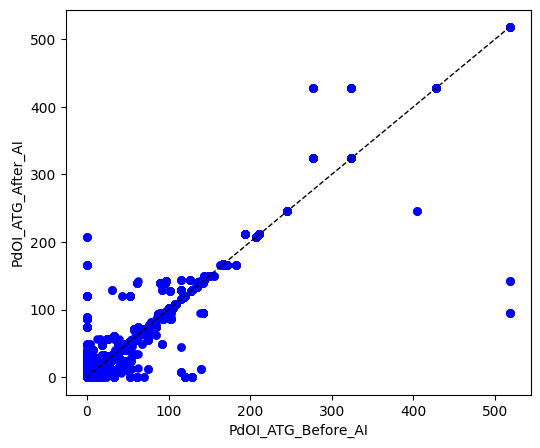

In [68]:
scatter_plot_models(target_test,dc_predictions,'Dummy')
scatter_plot_models(target_test,lr_predictions,'Linear')
scatter_plot_models(target_test,dt_predictions,'DecisionTree',show=True)
scatter_plot_models(target_test,rf_predictions,'RandomForest')
scatter_plot_models(target_test,xgb_predictions,'XGBoost')
scatter_plot_models(target_test,gb_predictions,'GradientBoost')
scatter_plot_models(target_test,knn_predictions,'KNeighbors')
scatter_plot_models(target_test,cb_predictions,'CatBoost')

## Reconstructing Original Data

In [69]:
original_data = get_data(columns=columns)

In [70]:
original_data['PdOI_ATG'] = original_data['PdOI_ATG'].astype(float)

In [71]:
features_train_unscaled,features_test_unscaled = train_test_split(original_data,random_state=random_state,test_size=0.95,shuffle=True)

In [72]:
df_with_predictions = concat([DataFrame(features_test_unscaled).reset_index(drop=True),dc_predictions,lr_predictions,dt_predictions,rf_predictions,xgb_predictions,gb_predictions,lgbm_predictions,cb_predictions,knn_predictions],axis=1)

## Displaying Discrepancies

In [73]:
options.display.float_format = '{:.4f}'.format

In [74]:
df_with_predictions[(abs(df_with_predictions['DecisionTree']-df_with_predictions['PdOI_ATG'])>(df_with_predictions['PdOI_ATG']/20))&
                    (abs(df_with_predictions['PdOI_ATG']-df_with_predictions['DecisionTree'])>0.001)].to_csv("C:/Code/Python/Machine_Learning_AI/Discrepancies/Worst_Discrepancies.csv",index=False)

In [75]:
df_with_predictions[(abs(df_with_predictions['DecisionTree']-df_with_predictions['PdOI_ATG'])>(df_with_predictions['PdOI_ATG']/20))&
                    (abs(df_with_predictions['PdOI_ATG']-df_with_predictions['DecisionTree'])>0.001)].sample(5)

,IsClaimFlg,Checked,ATG_Ref,ATG_LI_Ref,BatchNbr,CATEGORY_ATG,ClaimType,AP_VndNbr,APVndrName,OOB_ATG,ItemNbr,UPCNbr,UPCUnit,ItemDescription,ItemShipPack,PoNbr,PODate,ReceivingDate,TurnRatio_ATG,TurnQty_ATG,OrdQty,PdQty_ATG,PdGross_ATG,PdOI_ATG,PdBB_ATG,PdNet_ATG,DealNbr,OrdStartDate_ATG,OrdEndDate_ATG,DateStartArrival_ATG,DateEndArrival_ATG,DLAmtOI,DLAmtBB,Dummy,Linear,DecisionTree,RandomForest,XGBoost,GradientBoost,LGBM,CatBoost,KNeighbors
481498,N,x,16746351,671567027,88,SAME VENDOR - AMT DEALS,IN DEAL,GREEN MOUNT1,KEURIG GREEN MOUNTAIN,0.0200,40678,9955538663,9955538663,GRN MNT NANTUCKET BLND MED RST,6,810053,2023-07-20,2023-07-28,2.67,75.0000,200.0000,200.0000,48.4200,9.8400,3.0600,35.5200,714725,2023-03-01,2023-08-23,2023-03-01,2023-08-30,0.0000,3.0600,2.7600,9.8138,12.7800,7.5955,9.9726,3.2214,8.0235,10.0556,8.2200
738221,N,x,12560266,487182317,74,SAME VENDOR - AMT DEALS,IN DEAL,NTC MARKETI1,NTC MARKETING INC,-1.2700,21418,7458407530,7458407530,LIBBY NSA MANDARIN ORANGES,12,672725,2021-12-27,2022-01-05,1.14,98.0000,112.0000,112.0000,17.0400,3.7500,0.0000,13.2900,641818,2022-01-01,2022-07-01,2022-01-01,2022-07-01,4.2800,0.0000,2.7600,3.7590,4.0400,4.1522,4.1857,4.2497,4.3395,4.1812,3.9433
223855,N,x,18842287,719356758,96,SAME VENDOR - AMT DEALS,IN DEAL,SABRA DIPPI1,SABRA DIPPING CO LLC,0.0000,5096,1004082201154,4082201154,SABRA RSTD RED PEP HUM,12,854702,2024-02-20,2024-03-05,0.33,120.0000,40.0000,40.0000,29.5200,2.4500,0.0000,27.0700,777702,2024-02-04,2024-12-28,2024-02-04,2024-12-28,2.4500,0.0000,2.7600,2.4367,0.0000,2.3942,2.4155,2.4498,2.6131,2.3403,2.0600
422107,N,x,12051847,482554262,72,SAME VENDOR - AMT DEALS,IN DEAL,GENERAL00149,GENERAL MILLS FINANCE,0.0000,12285,1600017761,1600016383,GMI HONEY NUT CHEERIOS MEGA/GI,8,668150,2021-12-08,2021-12-27,0.40,90.0000,36.0000,36.0000,42.3200,5.6800,0.0000,36.6400,626590,2021-12-06,2022-01-16,2021-12-06,2022-01-16,5.6800,0.0000,2.7600,5.6638,7.3200,5.7006,5.5855,5.6811,5.5572,5.8363,5.2767
906082,N,x,18839938,718248338,96,SAME VENDOR - AMT DEALS,IN DEAL,MOTT'S 03154,DPS BEVERAGES INC,-599.5500,25143,1480000748,1480000747,MOTTS MIGHTY FLYN FRUIT PUNCH,8,853763,2024-02-15,2024-02-23,1.00,50.0000,50.0000,50.0000,23.6800,2.2400,0.0000,21.4400,761908,2024-01-01,2024-03-31,2024-01-01,2024-03-31,2.2400,0.0000,2.7600,2.2419,2.8000,2.3942,2.3014,2.2400,2.3991,2.2597,2.4267


In [76]:
df_with_predictions[
                        (
                            (abs(df_with_predictions['PdOI_ATG']-df_with_predictions['Linear'])>=(df_with_predictions['PdOI_ATG']/5))&
                            (abs(df_with_predictions['PdOI_ATG']-df_with_predictions['DecisionTree'])>=(df_with_predictions['PdOI_ATG']/5))&
                            (abs(df_with_predictions['PdOI_ATG']-df_with_predictions['RandomForest'])>=(df_with_predictions['PdOI_ATG']/5))&
                            (abs(df_with_predictions['PdOI_ATG']-df_with_predictions['XGBoost'])>=(df_with_predictions['PdOI_ATG']/5))&
                            (abs(df_with_predictions['PdOI_ATG']-df_with_predictions['GradientBoost'])>=(df_with_predictions['PdOI_ATG']/5))&
                            (abs(df_with_predictions['PdOI_ATG']-df_with_predictions['LGBM'])>=(df_with_predictions['PdOI_ATG']/5))&
                            (abs(df_with_predictions['PdOI_ATG']-df_with_predictions['CatBoost'])>=(df_with_predictions['PdOI_ATG']/5))&
                            (abs(df_with_predictions['PdOI_ATG']-df_with_predictions['KNeighbors'])>=(df_with_predictions['PdOI_ATG']/5))&
                            (df_with_predictions['PdOI_ATG']<0.01)
                        )
                    ].to_csv(f"C:/Code/Python/Machine_Learning_AI/Discrepancies/PdOI_Before_AI_0_And_Models_Not_0.csv")

## Export Discrepancies to SQL

In [77]:
data = df_with_predictions[
                        (
                            (abs(df_with_predictions['PdOI_ATG']-df_with_predictions['Linear'])>=(df_with_predictions['PdOI_ATG']/5))&
                            (abs(df_with_predictions['PdOI_ATG']-df_with_predictions['DecisionTree'])>=(df_with_predictions['PdOI_ATG']/5))&
                            (abs(df_with_predictions['PdOI_ATG']-df_with_predictions['RandomForest'])>=(df_with_predictions['PdOI_ATG']/5))&
                            (abs(df_with_predictions['PdOI_ATG']-df_with_predictions['XGBoost'])>=(df_with_predictions['PdOI_ATG']/5))&
                            (abs(df_with_predictions['PdOI_ATG']-df_with_predictions['GradientBoost'])>=(df_with_predictions['PdOI_ATG']/5))&
                            (abs(df_with_predictions['PdOI_ATG']-df_with_predictions['LGBM'])>=(df_with_predictions['PdOI_ATG']/5))&
                            (abs(df_with_predictions['PdOI_ATG']-df_with_predictions['CatBoost'])>=(df_with_predictions['PdOI_ATG']/5))&
                            (abs(df_with_predictions['PdOI_ATG']-df_with_predictions['KNeighbors'])>=(df_with_predictions['PdOI_ATG']/5))&
                            (df_with_predictions['PdOI_ATG']<0.01)
                        )
                    ].reset_index(drop=True)

In [95]:
data.to_csv("C:/Code/Python/Machine_Learning_AI/Discrepancies/All_Model_Predictions_Significantly_Different_From_Original_PdOI_ATG_Where_Pd_OI_Zero.csv",index=False)

In [78]:
data_2 = df_with_predictions[
                        (
                            (df_with_predictions['Linear']>(df_with_predictions['PdOI_ATG']))&
                            (df_with_predictions['DecisionTree']>(df_with_predictions['PdOI_ATG']))&
                            (df_with_predictions['RandomForest']>(df_with_predictions['PdOI_ATG']))&
                            (df_with_predictions['XGBoost']>(df_with_predictions['PdOI_ATG']))&
                            (df_with_predictions['GradientBoost']>(df_with_predictions['PdOI_ATG']))&
                            (df_with_predictions['LGBM']>(df_with_predictions['PdOI_ATG']))&
                            (df_with_predictions['CatBoost']>(df_with_predictions['PdOI_ATG']))&
                            (df_with_predictions['KNeighbors']>(df_with_predictions['PdOI_ATG']))
                        )
                    ].reset_index(drop=True)

In [79]:
data_2.to_csv("C:/Code/Python/Machine_Learning_AI/Discrepancies/All_Model_Predictions_Bigger_Than_Original_PdOI_ATG.csv",index=False)

In [93]:
data_3 = df_with_predictions[
                        (
                            (abs(df_with_predictions['PdOI_ATG']-df_with_predictions['Linear'])>=(df_with_predictions['PdOI_ATG']/5))&
                            (abs(df_with_predictions['PdOI_ATG']-df_with_predictions['DecisionTree'])>=(df_with_predictions['PdOI_ATG']/5))&
                            (abs(df_with_predictions['PdOI_ATG']-df_with_predictions['RandomForest'])>=(df_with_predictions['PdOI_ATG']/5))&
                            (abs(df_with_predictions['PdOI_ATG']-df_with_predictions['XGBoost'])>=(df_with_predictions['PdOI_ATG']/5))&
                            (abs(df_with_predictions['PdOI_ATG']-df_with_predictions['GradientBoost'])>=(df_with_predictions['PdOI_ATG']/5))&
                            (abs(df_with_predictions['PdOI_ATG']-df_with_predictions['LGBM'])>=(df_with_predictions['PdOI_ATG']/5))&
                            (abs(df_with_predictions['PdOI_ATG']-df_with_predictions['CatBoost'])>=(df_with_predictions['PdOI_ATG']/5))&
                            (abs(df_with_predictions['PdOI_ATG']-df_with_predictions['KNeighbors'])>=(df_with_predictions['PdOI_ATG']/5))&
                            (df_with_predictions['PdOI_ATG']>0.01)
                        )
                    ].reset_index(drop=True)

In [97]:
data_3.to_csv("C:/Code/Python/Machine_Learning_AI/Discrepancies/All_Model_Predictions_Significantly_Different_From_Original_PdOI_ATG_Where_Pd_OI_NOT_Zero.csv",index=False)

In [ ]:
export_to_sql(data)

In [ ]:
export_to_sql(data_2)

In [94]:
export_to_sql(data_3)

100
